In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [2]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)

/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_90442/300413872.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device: cpu
Device:  cpu


43

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [5]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [6]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [7]:
@torch.no_grad()
def calculate_fid(real_imgs, fake_imgs, mnist_classifier):
    # Function to calculate the FID score

    def extract_features(images, model):
        # Function to extract features from images using the provided model
        model.eval()
        # with torch.no_grad():
        features = model.get_activations(images)
        return features.cpu().numpy()

    # Extract features from real and fake images
    real_features = extract_features(real_imgs, mnist_classifier)
    fake_features = extract_features(fake_imgs, mnist_classifier)

    fid_score = frechet_inception_distance(real_features, fake_features)
    
    return fid_score

In [8]:
@torch.no_grad()
def calculate_inception(fake_imgs, mnist_classifier):
    # Function to calculate the IS score
    mnist_classifier.eval()
    # with torch.no_grad():
    log_p_yx = mnist_classifier(fake_imgs)
    p_yx = torch.exp(log_p_yx).cpu().numpy()
    score = inception_score(p_yx)

    return score

In [9]:
def apply_unstructured_pruning(model, backbone=True, amount=0.5):
    """Applies unstructured L1 pruning to the specified layers in the model.
    
    Args:
        model (nn.Module): The neural network model to prune.
        backbone (bool): If True, prune only Conv2d layers. If False, prune all layers.
        amount (float): The fraction of weights to prune.
    """
    for module in model.modules():
        # If backbone is True, prune only Conv2d layers
        if backbone and isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
        # If backbone is False, prune all layers with weights
        elif not backbone and hasattr(module, 'weight'):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

In [10]:
def apply_structured_pruning(model, backbone=True, amount=0.5):
    """Applies structured Ln pruning to the specified layers in the model.
    
    Args:
        model (nn.Module): The neural network model to prune.
        backbone (bool): If True, prune only Conv2d layers. If False, prune all layers.
        amount (float): The fraction of weights to prune.
    """
    for module in model.modules():
        # If backbone is True, prune only Conv2d layers
        if backbone and isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)  # dim=0 for filter pruning)
            prune.remove(module, 'weight')
        # If backbone is False, prune all layers with weights
        elif not backbone and hasattr(module, 'weight'):
            prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)  # dim=0 for filter pruning)
            prune.remove(module, 'weight')

In [11]:
def get_pruned_model(model, struct=False, backbone=True, amount=0.2):
    pruned_model = copy.deepcopy(model)
    if struct:
        apply_structured_pruning(model=pruned_model, backbone=backbone, amount=amount)
    else:
        apply_unstructured_pruning(model=pruned_model, backbone=backbone, amount=amount)
    
    return pruned_model


In [56]:
def get_images(model, train=False):
    data_loader = train_loader if train else test_loader
    real_imgs = None
    for imgs, _ in data_loader:
        real_imgs = imgs.cpu() # Move to CPU 
        break  # Only one batch is needed
    
    batch_size = real_imgs.shape[0]
    callback = GenerateImagesCallback(batch_size=batch_size, vis_steps=8, num_steps=1)
    # sampler = Sampler(model=model.cnn, 
    #                   img_shape=(1,28,28),
    #                   sample_size=batch_size)
    # fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)
    fake_imgs = callback.generate_imgs(model)
    fake_imgs = fake_imgs.squeeze(0).cpu()

    return real_imgs, fake_imgs

In [13]:
@torch.no_grad()
def calculate_ood_detection(model, rand=True):
    # Function to calculate out-of-distribution detection score
    # rand=True: random samples 
    # rand=False: samples from the training set
    model.eval()
    if rand:
        rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
        rand_imgs = rand_imgs * 2 - 1.0
        rand_out = model.cnn(rand_imgs).mean()
        print(f"Average score for random images: {rand_out.item():4.2f}")
        return rand_out.item()

    else:
        train_imgs,_ = next(iter(train_loader))
        train_imgs = train_imgs.to(model.device)
        train_out = model.cnn(train_imgs).mean()
        print(f"Average score for training images: {train_out.item():4.2f}")
        return train_out.item()

In [14]:
@torch.no_grad()
def compare_images(img1, img2, model):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    img2 = (img2 + 1) / 2
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")
    return [score1.item(), score2.item()]

In [15]:
def transform_image(transformation, model):
    test_imgs, _ = next(iter(test_loader))
    exmp_img = test_imgs[0].to(model.device)
    transformed_img = None
    if transformation == "noise":
        transformed_img = exmp_img + torch.randn_like(exmp_img) * 0.3
        transformed_img.clamp_(min=-1.0, max=1.0)
    elif transformation == "flip":
        transformed_img = exmp_img.flip(dims=(1,2))
    elif transformation == "tiny":
        transformed_img = torch.zeros_like(exmp_img)-1
        transformed_img[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
    
    return exmp_img, transformed_img

In [16]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST_resnet18.ckpt")
model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
# model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(model, input_size=(1, 28, 28))
# pl.seed_everything(43)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
             Swish-2           [-1, 64, 14, 14]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
             Swish-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          36,928
             Swish-7             [-1, 64, 7, 7]               0
BasicResidualBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
            Swish-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
            Swish-12             [-1, 64, 7, 7]               0
BasicResidualBlock-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 1

# Post-training Pruning

## Ustructured

In [57]:
def pruned_scores(model, struct, backbone, train=False):
    fid_scores = []
    is_scores = []
    ood_scores = []
    structure = "Structured" if struct else "Unstructured"
    level = "Backbone" if backbone else "Global"
    print(f"------------------{structure} {level} Pruning------------------")
    for amount in np.arange(0.1, 1.0, 0.1):
        pruned_model = get_pruned_model(model, struct=struct, backbone=backbone, amount=amount)
        pruned_model.to(device)

        real_imgs, fake_imgs = get_images(pruned_model, train=train)
        fid_score = calculate_fid(real_imgs, fake_imgs, mnist_classifier)
        is_score = calculate_inception(fake_imgs, mnist_classifier)
        ood_score = calculate_ood_detection(pruned_model, rand=False)

        perc = amount * 100
        print(f"FID Score on {level} post-training pruning of {perc}% of the EBM: ", fid_score)
        print(f"IS Score on {level} post-training pruning of {perc}% of the EBM: ", is_score)
        print(f"OFD Score on {level} post-training pruning of {perc}% of the EBM: ", ood_score, "\n")

        fid_scores.append(-fid_score)
        is_scores.append(is_score)
        ood_scores.append(ood_score)

    return fid_scores, is_scores, ood_scores

In [58]:
un_backbone_fid_scores, un_backbone_is_scores, un_backbone_ood_scores = pruned_scores(model, struct=False, backbone=True, train=False)
print("\n")
un_global_fid_scores, un_global_is_scores, un_global_ood_scores = pruned_scores(model, struct=False, backbone=False, train=False)
print("\n")
struct_backbone_fid_scores, struct_backbone_is_scores, struct_backbone_ood_scores = pruned_scores(model, struct=True, backbone=True, train=False)
print("\n")
struct_global_fid_scores, struct_global_is_scores, struct_global_ood_scores = pruned_scores(model, struct=True, backbone=False, train=False)

------------------Unstructured Backbone Pruning------------------
Average score for training images: 0.00
FID Score on Backbone post-training pruning of 10.0% of the EBM:  5311.938219751288
IS Score on Backbone post-training pruning of 10.0% of the EBM:  1.1102422
OFD Score on Backbone post-training pruning of 10.0% of the EBM:  0.001413551508449018 

Average score for training images: 0.00
FID Score on Backbone post-training pruning of 20.0% of the EBM:  5246.595967145383
IS Score on Backbone post-training pruning of 20.0% of the EBM:  1.1317495
OFD Score on Backbone post-training pruning of 20.0% of the EBM:  0.001939685782417655 

Average score for training images: 0.00
FID Score on Backbone post-training pruning of 30.000000000000004% of the EBM:  5272.593718412339
IS Score on Backbone post-training pruning of 30.000000000000004% of the EBM:  1.1404402
OFD Score on Backbone post-training pruning of 30.000000000000004% of the EBM:  0.000537953048478812 

Average score for training i

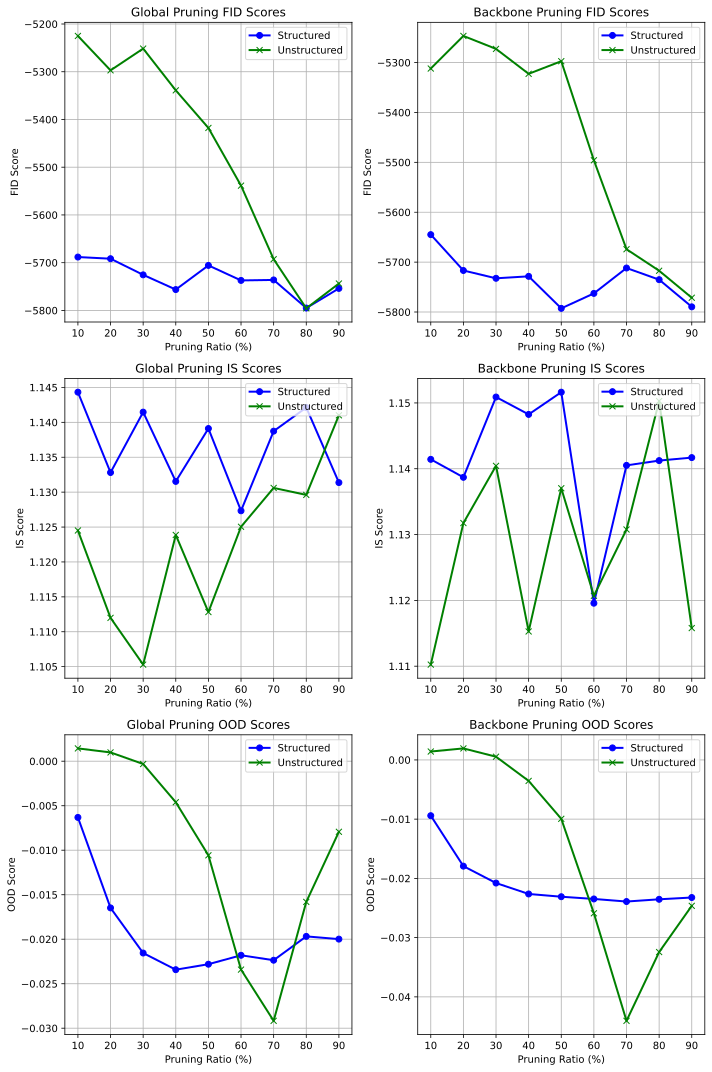

In [59]:
# Define pruning ratios
pruning_ratios = np.arange(10, 100, 10)  # from 10% to 90%, as in your loops

# Plotting function
def plot_combined_scores(pruning_ratios, struct_scores, unstruct_scores, title, ylabel, ax):
    ax.plot(pruning_ratios, struct_scores, label='Structured', color="blue", marker='o')
    ax.plot(pruning_ratios, unstruct_scores, label='Unstructured', color="green", marker='x')
    ax.set_xlabel('Pruning Ratio (%)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.grid(True)

# Create a figure and axis objects
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # 2x2 grid

# Plot combined scores for global pruning
plot_combined_scores(pruning_ratios, struct_global_fid_scores, un_global_fid_scores,
                     'Global Pruning FID Scores', 'FID Score', axs[0, 0])
plot_combined_scores(pruning_ratios, struct_global_is_scores, un_global_is_scores,
                     'Global Pruning IS Scores', 'IS Score', axs[1, 0])
plot_combined_scores(pruning_ratios, struct_global_ood_scores, un_global_ood_scores, 
                     'Global Pruning OOD Scores', 'OOD Score', axs[2, 0])


# Plot combined scores for backbone pruning
plot_combined_scores(pruning_ratios, struct_backbone_fid_scores, un_backbone_fid_scores,
                     'Backbone Pruning FID Scores', 'FID Score', axs[0, 1])
plot_combined_scores(pruning_ratios, struct_backbone_is_scores, un_backbone_is_scores,
                     'Backbone Pruning IS Scores', 'IS Score', axs[1, 1])
plot_combined_scores(pruning_ratios, struct_backbone_ood_scores, un_backbone_ood_scores, 
                     'Backbone Pruning OOD Scores', 'OOD Score', axs[2, 1])


# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

Seed set to 43


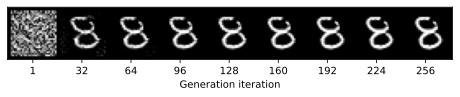

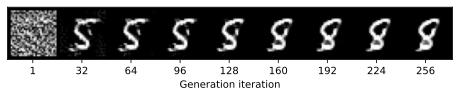

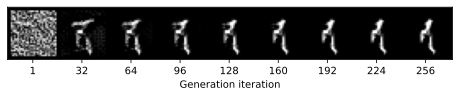

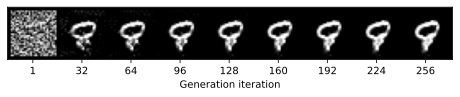

In [28]:
uns_pruned_model = get_pruned_model(model, struct=False, backbone=True, amount=0.2)
callback = GenerateImagesCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(uns_pruned_model)
imgs_per_step = imgs_per_step.cpu()
pl.seed_everything(43)

for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)

    # Normalize the images
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                
    # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()